In [2]:
import os
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from chestxray_module.dataset import load_split
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, recall_score
import numpy as np

In [ ]:
NUM_CLASSES = 3
BATCH_SIZE = 32
MAX_EPOCHS = 50

LR_BACKBONE = 1e-5
LR_HEAD = 1e-4
WEIGHT_DECAY = 1e-4

EARLY_STOPPING_PATIENCE = 5
MIN_DELTA = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_PATH = f"{os.getcwd()}/models/best_model.pt"
REPORT_PATH = f"{os.getcwd()}/reports/"
CLASS_NAMES = ["normal", "pneumonia", "tuberculosis"]

CHECKPOINT_PATH
REPORT_PATH

print(f"CHECKPOINT_PATH is {CHECKPOINT_PATH}")

print(f"CHECKPOINT_PATH is {CHECKPOINT_PATH}")

In [ ]:
# -----------------------------
# REPRODUCIBILITY
# -----------------------------

import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)              
np.random.seed(SEED)         
torch.manual_seed(SEED)       
torch.cuda.manual_seed_all(SEED)  

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
from chestxray_module.dataset import load_split

train_dataset = load_split('train')
val_dataset = load_split('val')

#len(train_dataset), train_dataset[0]['image'], train_dataset[0]['class'], train_dataset[0]['split'], train_dataset[0]['path']
#len(val_dataset), val_dataset[0]['image'], val_dataset[0]['class'], val_dataset[0]['split'], val_dataset[0]['path']


# CLASS_TO_IDX = {
#     "normal": 0,
#     "pneumonia": 1,
#     "tuberculosis": 2,
# }


# def __getitem__(self, i):
#     sample = self.data[i]

#     return {
#         "image": sample["image"],

#         # FIX: convert string → int tensor HERE
#         "class": torch.tensor(
#             CLASS_TO_IDX[sample["class"]],
#             dtype=torch.long
#         ),

#         "path": sample["path"],
#         "split": sample["split"],
#     }


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   # pickling issue with more than 0 workers
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)




# def __getitem__(self, i):
#     sample = self.data[i]

#     image = sample["image"]
#     label_str = sample["class"]

#     label = CLASS_TO_IDX[label_str]

#     return image, label


# batch = next(iter(train_loader))
# print(type(batch))
# print(len(batch))

# for i, item in enumerate(batch):
#     print(f"Item {i}: type={type(item)}")



Transformation + augmentation done successfully on training data.
20450 images in train_data.
Transformation done successfully.
2534 images in val_data.


In [7]:

# -----------------------------
# MODEL
# -----------------------------

# Load pretrained DenseNet
model = models.densenet121(weights="IMAGENET1K_V1")

# Replace classifier head for multi-class output
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),           # regularization
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(DEVICE)


In [8]:

# -----------------------------
# LOSS FUNCTION
# -----------------------------
# pneumonia gets higher weight because it is under-represented compared to TB and has high cost of misclassification, TB less weight as it is over-represented
# normal gets the least weight. 
class_weights = torch.tensor([0.5, 2.0, 1.0], device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [9]:
# -----------------------------
# OPTIMIZER (DIFFERENTIAL LR)
# -----------------------------

optimizer = torch.optim.AdamW(
    [
        {"params": model.features.parameters(), "lr": LR_BACKBONE},
        {"params": model.classifier.parameters(), "lr": LR_HEAD},
    ],
    weight_decay=WEIGHT_DECAY,
)

In [10]:
# -----------------------------
# SCHEDULER
# -----------------------------

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",           # we monitor AUROC (higher is better)
    factor=0.1,
    patience=2,
    #verbose=True,
)

In [11]:

# -----------------------------
# METRIC HELPERS
# -----------------------------

def compute_metrics(y_true, y_probs):
    """
    Computes Macro AUROC and Macro F1.
    y_true: (N,)
    y_probs: (N, C)
    """
    auroc = roc_auc_score(
        y_true,
        y_probs,
        multi_class="ovr",
        average="macro"
    )

    y_pred = np.argmax(y_probs, axis=1)
    f1 = f1_score(y_true, y_pred, average="macro")
    
    recall_per_class = recall_score(
    y_true,
    y_pred,
    average=None
    )

    return auroc, f1, recall_per_class


In [12]:

# -----------------------------
# TRAIN / VALIDATION LOOPS
# -----------------------------

def train_one_epoch(model, loader):
    model.train()

    running_loss = 0.0
    all_targets, all_probs = [], []
    
    for batch in tqdm(loader, desc="Training", leave=False):
        images = batch["image"].to(DEVICE)
        labels = batch["class"].to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.softmax(logits, dim=1)
        all_targets.append(labels.cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_probs = np.concatenate(all_probs)

    auroc, f1, recall_per_class = compute_metrics(all_targets, all_probs)
    avg_loss = running_loss / len(loader.dataset)

    return avg_loss, auroc, f1, recall_per_class, all_targets, all_probs


@torch.no_grad()
def validate_one_epoch(model, loader):
    model.eval()

    running_loss = 0.0
    all_targets, all_probs = [], []

    for batch in tqdm(loader, desc="Validating", leave=False):
        images = batch["image"].to(DEVICE)
        labels = batch["class"].to(DEVICE)
        
        logits = model(images)
        loss = criterion(logits, labels)

        running_loss += loss.item() * images.size(0)

        probs = torch.softmax(logits, dim=1)
        all_targets.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_probs = np.concatenate(all_probs)

    auroc, f1, recall_per_class = compute_metrics(all_targets, all_probs)
    avg_loss = running_loss / len(loader.dataset)

    return avg_loss, auroc, f1, recall_per_class, all_targets, all_probs

In [13]:
# -----------------------------
# TRAINING LOOP (WITH EARLY STOPPING)
# -----------------------------
CLASS_NAMES = ["normal", "pneumonia", "tuberculosis"]
# Enable MLflow autologging ONCE (before training)
import mlflow
import mlflow.pytorch

mlflow.autolog(
    log_models=False  # IMPORTANT: we manually log the BEST model
)

best_val_auroc = -np.inf
epochs_without_improvement = 0

with mlflow.start_run(run_name="DenseNet_Multiclass_ChestXray"):

    for epoch in range(1, MAX_EPOCHS + 1):

        train_loss, train_auroc, train_f1, train_recall_per_class, _, _ = train_one_epoch(model, train_loader)
        val_loss,   val_auroc,   val_f1,    val_recall_per_class , val_targets, val_probs  = validate_one_epoch(model, val_loader)

        
        mlflow.log_metrics(
            {
                "train_auroc": train_auroc,
                "val_auroc": val_auroc,
                "train_f1": train_f1,
                "val_f1": val_f1
            },
            step=epoch,
        )

        # Per-class recall (clinical metrics)
        for i, class_name in enumerate(CLASS_NAMES):
            mlflow.log_metric(
                f"train_recall_{class_name}",
                train_recall_per_class[i],
                step=epoch,
            )
            mlflow.log_metric(
                f"val_recall_{class_name}",
                val_recall_per_class[i],
                step=epoch,
            )
            
        print(
          f"Epoch {epoch:03d} | "
          f"Train AUROC: {train_auroc:.4f} | "
          f"Val AUROC: {val_auroc:.4f} | "
          f"Train F1: {train_f1:.4f} | "
          f"Val F1: {val_f1:.4f} | "
          f"Val Recall "
          f"Normal={val_recall_per_class[0]:.3f}, "
          f"Pneumonia={val_recall_per_class[1]:.3f}, "
          f"TB={val_recall_per_class[2]:.3f}"
        )

            
        # ---- Scheduler ----
        scheduler.step(val_auroc)

        # Best model selection -> PRIMARY METRIC = val AUROC
        if val_auroc > best_val_auroc + MIN_DELTA:
            best_val_auroc = val_auroc
            epochs_without_improvement = 0

            # Save best model locally
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, CHECKPOINT_PATH)

            # Log BEST model explicitly
            mlflow.pytorch.log_model(
                model,
                artifact_path="best_model",
            )

            # Log best score
            mlflow.log_metric("best_val_auroc", best_val_auroc)

            print("  ✓ New best model saved")

        else:
            epochs_without_improvement += 1
            print(f"  ✗ No improvement ({epochs_without_improvement})")

        # ---- Early stopping ----
        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break




# best_val_auroc = -np.inf
# epochs_without_improvement = 0
# best_model_state = None

# for epoch in range(1, MAX_EPOCHS + 1):

#     train_loss, train_auroc, train_f1 = train_one_epoch(model, train_loader)
#     val_loss, val_auroc, val_f1 = validate_one_epoch(model, val_loader)

#     print(
#         f"Epoch {epoch:03d} | "
#         f"Train AUROC: {train_auroc:.4f} | "
#         f"Val AUROC: {val_auroc:.4f}"
#     )

#     # Scheduler reacts to validation performance
#     scheduler.step(val_auroc)

#     # Check improvement
#     if val_auroc > best_val_auroc + MIN_DELTA:
#         best_val_auroc = val_auroc
#         best_model_state = copy.deepcopy(model.state_dict())
#         torch.save(best_model_state, CHECKPOINT_PATH)
#         epochs_without_improvement = 0
#         print("  ✓ New best model saved")
#     else:
#         epochs_without_improvement += 1
#         print(f"  ✗ No improvement ({epochs_without_improvement})")

#     # Early stopping
#     if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
#         print("Early stopping triggered")
#         break



2026/01/10 18:33:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/01/10 18:33:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/10 18:33:41 INFO mlflow.store.db.utils: Updating database tables
2026/01/10 18:33:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/10 18:33:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/10 18:33:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/10 18:33:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/10 18:46:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 001 | Train AUROC: 0.8705 | Val AUROC: 0.9252 | Train F1: 0.6550 | Val F1: 0.7657 | Val Recall Normal=0.618, Pneumonia=1.000, TB=0.751


2026/01/10 18:46:07 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torchvision==0.24.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


  ✓ New best model saved


2026/01/10 18:57:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 002 | Train AUROC: 0.9192 | Val AUROC: 0.9317 | Train F1: 0.7372 | Val F1: 0.7449 | Val Recall Normal=0.404, Pneumonia=0.998, TB=0.934


2026/01/10 18:57:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torchvision==0.24.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


  ✓ New best model saved


2026/01/10 19:08:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 003 | Train AUROC: 0.9298 | Val AUROC: 0.9329 | Train F1: 0.7500 | Val F1: 0.7639 | Val Recall Normal=0.513, Pneumonia=1.000, TB=0.856


2026/01/10 19:08:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torchvision==0.24.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


  ✓ New best model saved


Epoch 004 | Train AUROC: 0.9347 | Val AUROC: 0.9334 | Train F1: 0.7602 | Val F1: 0.7546 | Val Recall Normal=0.469, Pneumonia=1.000, TB=0.882
  ✗ No improvement (1)


Epoch 005 | Train AUROC: 0.9380 | Val AUROC: 0.9320 | Train F1: 0.7627 | Val F1: 0.7473 | Val Recall Normal=0.384, Pneumonia=1.000, TB=0.969
  ✗ No improvement (2)


Epoch 006 | Train AUROC: 0.9396 | Val AUROC: 0.9322 | Train F1: 0.7611 | Val F1: 0.7497 | Val Recall Normal=0.407, Pneumonia=0.998, TB=0.946
  ✗ No improvement (3)


Epoch 007 | Train AUROC: 0.9407 | Val AUROC: 0.9307 | Train F1: 0.7629 | Val F1: 0.7477 | Val Recall Normal=0.383, Pneumonia=0.998, TB=0.973
  ✗ No improvement (4)


Epoch 008 | Train AUROC: 0.9427 | Val AUROC: 0.9309 | Train F1: 0.7639 | Val F1: 0.7527 | Val Recall Normal=0.424, Pneumonia=0.998, TB=0.933
  ✗ No improvement (5)
Early stopping triggered


In [14]:
# # check labels
# for i in range(20):
#     s = val_loader.dataset[i]  # or val_dataset[i]
#     print(i, s["class"], s.get("split", None), type(s["class"]))
    
# for i in range(50):
#     s = val_loader.dataset[i]  # or val_dataset[i]
#     print(
#         i,
#         s["class"],
#         s.get("split", None),
#         type(s["class"])
#     )

import random
indices = random.sample(range(len(val_loader.dataset)), 30)

for i in indices:
    s = val_loader.dataset[i]
    print(
        i,
        s["class"],
        s.get("split", None),
        type(s["class"])
    )


456 tensor(0) val <class 'torch.Tensor'>
102 tensor(0) val <class 'torch.Tensor'>
1126 tensor(2) val <class 'torch.Tensor'>
1003 tensor(2) val <class 'torch.Tensor'>
914 tensor(2) val <class 'torch.Tensor'>
571 tensor(0) val <class 'torch.Tensor'>
419 tensor(0) val <class 'torch.Tensor'>
2233 tensor(1) val <class 'torch.Tensor'>
356 tensor(0) val <class 'torch.Tensor'>
2418 tensor(1) val <class 'torch.Tensor'>
1728 tensor(2) val <class 'torch.Tensor'>
130 tensor(0) val <class 'torch.Tensor'>
122 tensor(0) val <class 'torch.Tensor'>
383 tensor(0) val <class 'torch.Tensor'>
895 tensor(0) val <class 'torch.Tensor'>
952 tensor(2) val <class 'torch.Tensor'>
2069 tensor(1) val <class 'torch.Tensor'>
2465 tensor(1) val <class 'torch.Tensor'>
108 tensor(0) val <class 'torch.Tensor'>
2298 tensor(1) val <class 'torch.Tensor'>
814 tensor(0) val <class 'torch.Tensor'>
2232 tensor(1) val <class 'torch.Tensor'>
1718 tensor(2) val <class 'torch.Tensor'>
902 tensor(2) val <class 'torch.Tensor'>
1839 t

In [ ]:
# Using val_targets and val_probs
# sanity check: shuffle labels and compute AUROC
rng = np.random.default_rng(0)
shuffled = rng.permutation(val_targets)

print(
    "AUROC shuffled:",
    roc_auc_score(
        shuffled,
        val_probs,
        multi_class="ovr",
        average="macro"
    )
)


AUROC shuffled: 0.49270282589122294


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predicted class = argmax probability
y_pred = np.argmax(val_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(val_targets, y_pred)

print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

# Human-readable report
print(
    classification_report(
        val_targets,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4
    )
)


Confusion Matrix (rows=true, cols=pred):
[[382 171 347]
 [  1 569   0]
 [ 67   4 993]]
              precision    recall  f1-score   support

      normal     0.8489    0.4244    0.5659       900
   pneumonia     0.7648    0.9982    0.8661       570
tuberculosis     0.7410    0.9333    0.8261      1064

    accuracy                         0.7672      2534
   macro avg     0.7849    0.7853    0.7527      2534
weighted avg     0.7847    0.7672    0.7427      2534



In [ ]:
# labels_in_val = set()

# for batch in val_loader:
#     labels_in_val.update(batch["class"].tolist())

# labels_in_val



# labels_in_train= set()

# for batch in train_loader:
#     labels_in_train.update(batch["class"].tolist())

# labels_in_train

{0, 1, 2}

In [17]:
# -----------------------------
# LOAD BEST MODEL
# -----------------------------

model.load_state_dict(torch.load(CHECKPOINT_PATH))
print(f"Best validation AUROC: {best_val_auroc:.4f}")

Best validation AUROC: 0.9329


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

all_targets = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["class"].to(DEVICE)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_targets.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_preds = np.concatenate(all_preds)


2026/01/10 20:44:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Confusion Matrix:
                    pred_normal  pred_pneumonia  pred_tuberculosis
true_normal                462             171                267
true_pneumonia               0             570                  0
true_tuberculosis          151               2                911


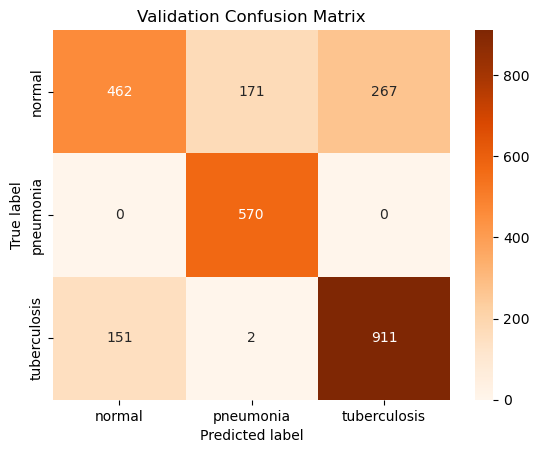

,precision,recall,f1-score,support
normal,0.753670,0.513333,0.610707,900.000000
pneumonia,0.767160,1.000000,0.868241,570.000000
tuberculosis,0.773345,0.856203,0.812667,1064.000000
accuracy,0.766772,0.766772,0.766772,0.766772
macro avg,0.764725,0.789845,0.763872,2534.000000
weighted avg,0.764966,0.766772,0.753438,2534.000000


<Figure size 640x480 with 0 Axes>

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_targets, all_preds)

cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in CLASS_NAMES],
    columns=[f"pred_{c}" for c in CLASS_NAMES],
)
print("Confusion Matrix:\n", cm_df)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cmap="Oranges",
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Validation Confusion Matrix")
plt.show()
plt.savefig("reports/figures/confusion_matrix_heatmap.png", dpi=300)

report_dict = classification_report(
    all_targets,
    all_preds,
    target_names=CLASS_NAMES,
    digits=4,
    output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()
report_df



In [20]:
cm_df.to_csv(REPORT_PATH + "confusion_matrix.csv")
report_df.to_csv(REPORT_PATH + "metrics_report.csv")